In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import anndata as ad
import multigrate as mtg
import numpy as np
import pandas as pd
import gdown
import scipy

sc.logging.print_versions()

scanpy==1.4.6 anndata==0.7.3 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.6.1


In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(Seurat)
library(SeuratDisk)
library(Signac)

R[write to console]: Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

R[write to console]: Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

R[write to console]: 
Attache Paket: 'Signac'


R[write to console]: Следующий объект скрыт от 'package:Seurat':

    FoldChange




# Expressions

## Download the data

In [4]:
gdown.download(
    'https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN',
    '10xpbmc10k-expressions.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1QK5Ua4HStjIm3URxw4WHHM2gdzDmbvsN
To: /Users/alitinet/Desktop/thesis/multigrate/10xpbmc10k-expressions.h5ad
48.8MB [02:04, 391kB/s]


'10xpbmc10k-expressions.h5ad'

In [5]:
adata = sc.read('10xpbmc10k-expressions.h5ad')
adata

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

## Save raw counts

In [6]:
adata_ = ad.AnnData(adata.layers['count'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.write('expressions_hvg_counts.h5ad')

## Convert h5ad file with raw counts to a h5Seurat object

In [7]:
%%R
Convert('expressions_hvg_counts.h5ad', 'h5seurat', overwrite=TRUE)

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var



# Protein

## Download the data

In [8]:
gdown.download(
    'https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc',
    '10xpbmc10k-peaks.h5ad'
)

Downloading...
From: https://drive.google.com/uc?id=1OkryKwFCna0hWD_oUiRFknzVy72oaFfc
To: /Users/alitinet/Desktop/thesis/multigrate/10xpbmc10k-peaks.h5ad
789MB [25:24, 517kB/s] 


'10xpbmc10k-peaks.h5ad'

In [9]:
adata = sc.read('10xpbmc10k-peaks.h5ad')
adata

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Save raw counts

In [10]:
adata_ = ad.AnnData(adata.layers['binary'])
adata_.obs_names = adata.obs_names
adata_.var_names = adata.var_names
adata_.obs['cell_type'] = adata.obs['cell_type']
adata_.write('peaks_binary.h5ad')

## Convert h5ad file with raw counts to a h5Seurat object

In [11]:
%%R
Convert('peaks_binary.h5ad', 'h5seurat', overwrite=TRUE)

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var



# Run Seurat v4 WNN
Following https://satijalab.org/seurat/v4.0/weighted_nearest_neighbor_analysis.html.

In [12]:
%%R
rna <- LoadH5Seurat("expressions_hvg_counts.h5seurat")
peaks <- LoadH5Seurat("peaks_binary.h5seurat")

bm <- rna
bm[["ATAC"]] <- CreateAssayObject(counts = peaks@assays$RNA@counts)

rm(rna)
rm(peaks)

print('Preprocessing RNA...')
DefaultAssay(bm) <- "RNA"
bm <- SCTransform(bm, variable.features.n = 3999, verbose=FALSE)
bm <- RunPCA(bm, verbose=FALSE)
bm <- RunUMAP(bm, dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

print('Preprocessing ATAC...')
DefaultAssay(bm) <- "ATAC"
bm <- RunTFIDF(bm, verbose=FALSE)
bm <- FindTopFeatures(bm, min.cutoff = 'q0', verbose=FALSE)
bm <- RunSVD(bm, verbose=FALSE)
bm <- RunUMAP(bm, reduction = 'lsi', dims = 2:50, reduction.name = "umap.atac", 
              reduction.key = "atacUMAP_", verbose=FALSE)

bm <- FindMultiModalNeighbors(bm, reduction.list = list("pca", "lsi"), 
                              dims.list = list(1:50, 2:50), modality.weight.name = "RNA.weight")

bm <- RunUMAP(bm, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_", verbose=FALSE)
bm <- FindClusters(bm, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

SaveH5Seurat(bm, 'integrated_10xpbmc.h5seurat', overwrite = TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing RNA with data

R[write to console]: Adding counts for RNA

R[write to console]: Adding feature-level metadata for RNA

R[write to console]: Adding command information

R[write to console]: Adding cell-level metadata

R[write to console]: Adding miscellaneous information

R[write to console]: Adding tool-specific results

R[write to console]: Validating h5Seurat file

R[write to console]: Initializing RNA with data

R[write to console]: Adding counts for RNA

R[write to console]: Adding feature-level metadata for RNA

R[write to console]: Adding command information

R[write to console]: Adding cell-level metadata

R[write to console]: Adding miscellaneous information

R[write to console]: Adding tool-specific results



[1] "Preprocessing RNA..."


R[write to console]: Warnung:
R[write to console]:  The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session



[1] "Preprocessing ATAC..."


R[write to console]: Calculating cell-specific modality weights

R[write to console]: Finding 20 nearest neighbors for each modality.



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~03s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=05s  


R[write to console]: Calculating kernel bandwidths



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  


R[write to console]: Finding multimodal neighbors



  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~09s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=20s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  


R[write to console]: Constructing multimodal KNN graph

R[write to console]: Constructing multimodal SNN graph

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding counts for RNA

R[write to console]: Adding data for RNA

R[write to console]: No variable features found for RNA

R[write to console]: No feature-level metadata found for RNA

R[write to console]: Adding counts for ATAC

R[write to console]: Adding data for ATAC

R[write to console]: Adding variable features for ATAC

R[write to console]: Adding feature-level metadata for ATAC

R[write to console]: Adding counts for SCT

R[write to console]: Adding data for SCT

R[write to console]: Adding scale.data for SCT

R[write to console]: Adding variable features for SCT

R[write to console]: Adding feature-level metadata for SCT

R[write to console]: Adding cell embeddings for pca

R[write to console]: Adding loadings for pca

R[write to console]: No projected loadings for pca

R[write to

In [13]:
%%R
# wsnn graph is stored in SCT assay
Convert("integrated_10xpbmc.h5Seurat", assay="SCT", "integrated_10xpbmc.h5ad", overwrite=TRUE)

R[write to console]: Validating h5Seurat file

R[write to console]: Adding scale.data from SCT as X

R[write to console]: Transfering meta.features to var

R[write to console]: Adding data from SCT as raw

R[write to console]: Transfering meta.features to raw/var

R[write to console]: Transfering meta.data to obs

R[write to console]: Adding dimensional reduction information for pca

R[write to console]: Adding feature loadings for pca

R[write to console]: Adding dimensional reduction information for umap.rna

R[write to console]: Adding dimensional reduction information for umap.atac (global)

R[write to console]: Adding dimensional reduction information for wnn.umap (global)

R[write to console]: Adding wsnn as neighbors



## Visualize the result

In [14]:
integrated = sc.read('integrated_10xpbmc.h5ad')
integrated

AnnData object with n_obs × n_vars = 10000 × 3808
    obs: 'cell_type', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'RNA.weight', 'wsnn_res.0.8', 'seurat_clusters'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap.atac', 'X_umap.rna', 'X_wnn.umap'
    varm: 'PCs'
    obsp: 'distances'

Cell types don't transfer properly due to a SeuratDisk bug so set them manually (https://github.com/mojaveazure/seurat-disk/issues/23).

In [15]:
# check indices
np.sum(adata.obs['cell_type'].index != integrated.obs['cell_type'].index)

0

In [16]:
integrated.obs['cell_type'] = adata.obs['cell_type']

In [17]:
integrated.obs['seurat_clusters'] = integrated.obs['seurat_clusters'].astype('category')

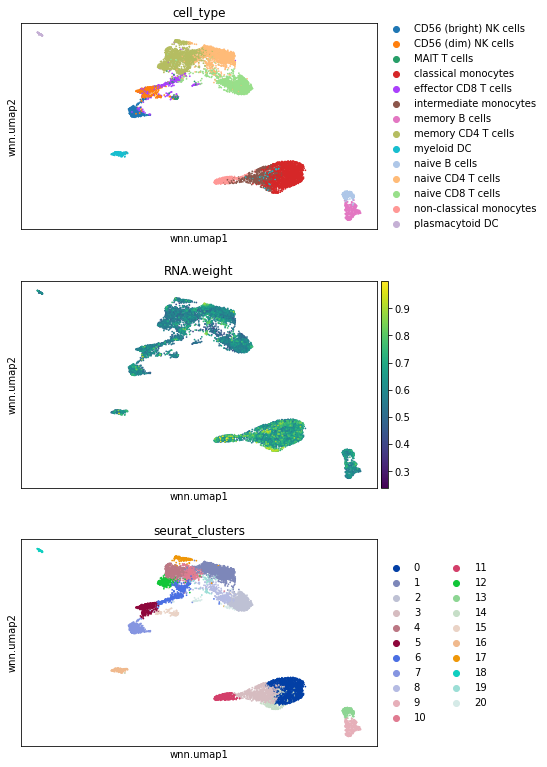

In [18]:
sc.pl.embedding(integrated, basis='wnn.umap', color=['cell_type', 'RNA.weight', 'seurat_clusters'], ncols=1)

## Run metrics

SeuratDisk writes the neighbors graph from the Seurat object to `.uns['neighbors']['distances']`, so change the location to `.uns['neighbors']['connectivities']`.

In [20]:
integrated.uns['neighbors']['connectivities'] = integrated.uns['neighbors']['distances']

In [21]:
integrated.write('integrated_10xpbmc.h5ad')

We only can run graph-based metrics. We don't run `isolated_label_f1` because it requires batch labels, but we treat datasets as batches, i.e. here we have one dataset = one batch, so don't use it.

In [22]:
metrics = mtg.metrics.metrics(
    None, integrated,
    batch_key=None,
    label_key='cell_type',
    method='seurat',
    asw_label=False, 
    asw_batch=False,
    pcr_batch=False, 
    graph_connectivity_batch=True, 
    nmi_=True, 
    ari_=True,
    isolated_label_asw=False, 
    isolated_label_f1=False
)
metrics

Clustering...
Graph connectivity...
NMI cluster/label...
ARI cluster/label...


,score
graph_conn,0.976630
NMI_cluster/label,0.786914
ARI_cluster/label,0.713924


Finally, remove unnecessary files. 

In [23]:
!rm '10xpbmc10k-expressions.h5ad'
!rm '10xpbmc10k-peaks.h5ad'
!rm 'expressions_hvg_counts.h5ad'
!rm 'peaks_binary.h5ad'
!rm 'expressions_hvg_counts.h5seurat'
!rm 'peaks_binary.h5seurat'
!rm 'integrated_10xpbmc.h5Seurat'

In [24]:
%%R
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Users/alitinet/opt/miniconda3/envs/scmulti/lib/python3.7/site-packages/numpy/.dylibs/libopenblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] Signac_1.1.0          SeuratDisk_0.0.0.9013 Seurat_3.9.9.9010    

loaded via a namespace (and not attached):
  [1] reticulate_1.18             tidyselect_1.1.0           
  [3] RSQLite_2.2.1               AnnotationDbi_1.52.0       
  [5] htmlwidgets_1.5.2           grid_4.0.3                 
  [7] BiocParallel_1.24.1         Rtsne_0.15                 
  [9] munsell_0.5.0               codetools_0.2-18           
 [11] ica_1.0-2                   future_1.20.1              
 [13] miniUI_0.